Импортируем всё необходимое и добавляем аугментации train и val

In [283]:
import torch
import numpy as np
import torch.nn as nn
import torchvision.models as models
import os
import matplotlib.pyplot as plt
import cv2
import Augmentor

from torchvision import datasets
from torchvision import transforms
from torch.utils.data import DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.preprocessing import LabelEncoder
from torch.optim.lr_scheduler import CosineAnnealingLR
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split


In [284]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Подготовим датасет

train_transform = transforms.Compose([
	transforms.ToTensor(),
    transforms.Resize(224),
	transforms.RandomHorizontalFlip(p=0.3),
	transforms.RandomVerticalFlip(p=0.3),
	transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


val_transform = transforms.Compose([
	transforms.ToTensor(),
    transforms.Resize(224),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

train_foldr = 'train'
val_foldr = 'val'

Датасеты

In [285]:
# Создаём загрузчики DataLoader

train_im = datasets.ImageFolder(train_foldr, transform=train_transform)
val_im = datasets.ImageFolder(val_foldr, transform=val_transform)
train_loader = DataLoader(train_im, batch_size=32, shuffle=True)
val_loader = DataLoader(val_im, batch_size=32, shuffle=False)

Приготовим переменные для подсчёта лучших метрик

In [286]:
best_f1 = 0

# ОСТАВИТЬ F1

loss_train = []
loss_val = []

train_f1 = []
val_f1 = []

Добавим раннюю остановку модели

In [287]:
class EarlyStopping:
    def __init__(self, patience=5):
        self.patience = patience
        self.counter = 0
        self.best_loss = None

    def __call__(self, val_loss):
        if self.best_loss is None:
            self.best_loss = val_loss
        elif val_loss > self.best_loss:
            self.counter += 1
            if self.counter >= self.patience:
                return True
        else:
            self.best_loss = val_loss
            self.counter = 0
        return False

early_stopping = EarlyStopping(patience=10)

Инициализация модели

In [288]:
class CustomResNet(nn.Module):
    def __init__(self, num_classes=2):
        super(CustomResNet, self).__init__()
        self.resnet = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
        in_features = self.resnet.fc.in_features
        self.resnet.fc = nn.Linear(in_features, num_classes)

    def forward(self, x):
        return self.resnet(x)


resnet = CustomResNet(num_classes=2)

resnet.to(device)

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(resnet.parameters(), lr=0.0005, momentum=0.9)
num_epochs = 20


Тренируем

In [289]:
for epoch in range(num_epochs):
    print("TRAIN EPOCH:", epoch)
    
    resnet.train()
    epoch_loss = 0.0
    true_labels = []
    predicted = []
    
    i = 1
    
    # Тренировка
    
    for images, labels in train_loader:
        print(f'\rIteration: {100*i/len(train_loader)}%                          ', end='', flush=True)
        i += 1
        
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        
        outputs = resnet(images)
        _, pred = torch.max(outputs, 1)
        
        predicted.extend(pred.cpu().tolist())
        true_labels.extend(labels.cpu().tolist())
        
        loss = criterion(outputs, labels)
        loss.backward()
        
        optimizer.step()
        epoch_loss += loss.item()
    
    train_loss = epoch_loss / len(train_loader)
    train_f1_sc = f1_score(true_labels, predicted)
    
    print("\nTrain loss: ", train_loss)
    print("Train F1-Score:", train_f1_sc)
    # Валидация
    print("VALIDATION")
    
    resnet.eval()
    
    with torch.no_grad():

        true_labels = []
        predicted = []
        val_loss = 0.0
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            
            outputs = resnet(images)
            _, pred = torch.max(outputs, 1)
            predicted.extend(pred.cpu().tolist())
            true_labels.extend(labels.cpu().tolist())
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            
        avg_f1 = f1_score(true_labels, predicted)
        
        torch.save(resnet.state_dict(), f'resnet_epoch_{epoch}.pth')
        

        if avg_f1 > best_f1:
            best_f1 = avg_f1
            torch.save(resnet.state_dict(), f'resnet_best.pth')
        val_loss /= len(val_loader)
        print("\nVal loss:", val_loss)
        print("Val F1-Score: ", avg_f1)
        
        val_f1.append(avg_f1)
        train_f1.append(train_f1_sc)
        loss_val.append(val_loss)
        loss_train.append(train_loss)
        
        print("\n")
        
        # Автовыход из обучения
        if early_stopping(val_loss):
            print("Training stopped. Very small changes of validation loss")
            break
            

TRAIN EPOCH: 0
Iteration: 100.0%                                       
Train loss:  0.44734712223211925
Train F1-Score: 0.7842480100544617
VALIDATION

Val loss: 0.24948217053162425
Val F1-Score:  0.9094076655052264


TRAIN EPOCH: 1
Iteration: 100.0%                                       
Train loss:  0.2734919584790866
Train F1-Score: 0.8831061544816192
VALIDATION

Val loss: 0.1878902265115788
Val F1-Score:  0.928082191780822


TRAIN EPOCH: 2
Iteration: 100.0%                                       
Train loss:  0.22869370261828104
Train F1-Score: 0.9142857142857143
VALIDATION

Val loss: 0.1604100971629745
Val F1-Score:  0.9302325581395349


TRAIN EPOCH: 3
Iteration: 100.0%                                       
Train loss:  0.1988007567326228
Train F1-Score: 0.9247933884297521
VALIDATION

Val loss: 0.15445188815264324
Val F1-Score:  0.9387755102040817


TRAIN EPOCH: 4
Iteration: 100.0%                                       
Train loss:  0.1867703073223432
Train F1-Score: 0.92948453608

Проверка метрик

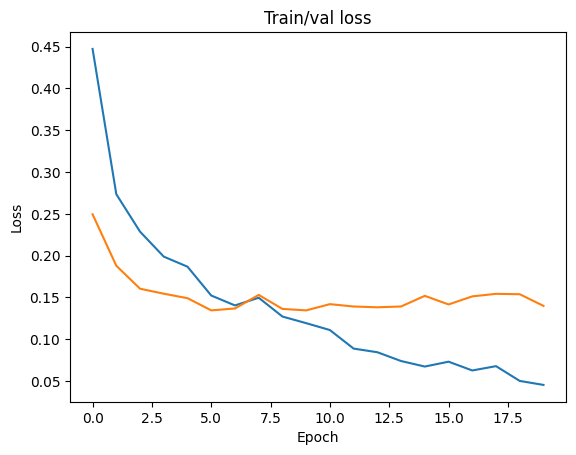

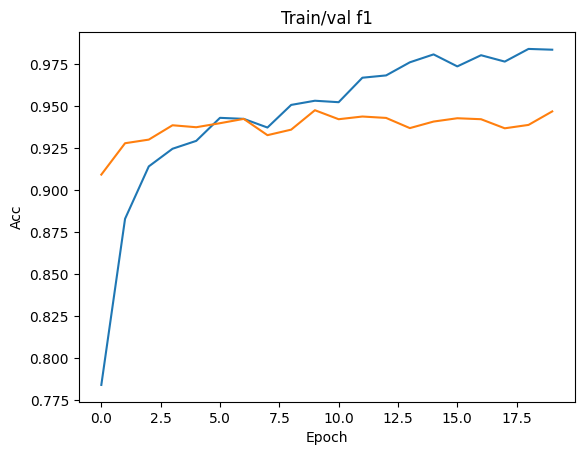

In [290]:
plt.plot(loss_train, label='train')
plt.plot(loss_val, label="val")
plt.title('Train/val loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()


plt.plot(train_f1, label='train')
plt.plot(val_f1, label='val')
plt.title('Train/val f1')
plt.xlabel('Epoch')
plt.ylabel('Acc')
plt.show()

Тестируем

In [291]:
testset = datasets.ImageFolder('test', transform=val_transform)
test_loader = DataLoader(testset, batch_size=32, shuffle=False)

true_labels = []
predicted = []

newnet = CustomResNet()
newnet.to(device)
newnet.load_state_dict(torch.load("resnet_best.pth"))

newnet.eval()

CustomResNet(
  (resnet): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track

In [292]:
for images, labels in test_loader:
	images, labels = images.to(device), labels.to(device)
	outputs = newnet(images)
	
	# Count labels
	_, pred = torch.max(outputs, 1)
	predicted.extend(pred.cpu().tolist())
	true_labels.extend(labels.cpu().tolist())

# F1
f1s = f1_score(true_labels, predicted)
print("TEST F1:", f1s)

TEST F1: 0.9337442218798151


Посмотрим, как работает модель

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


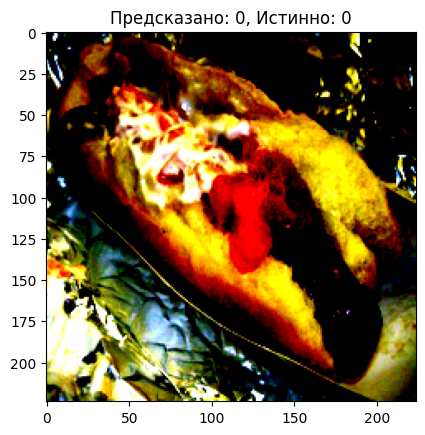

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


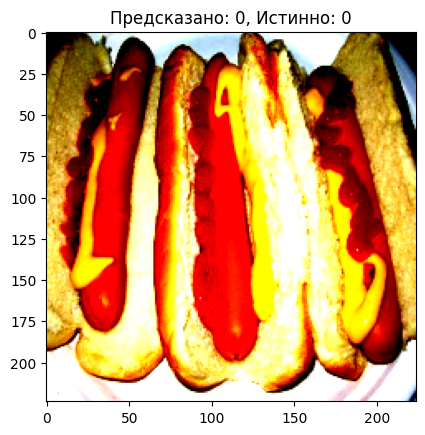

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


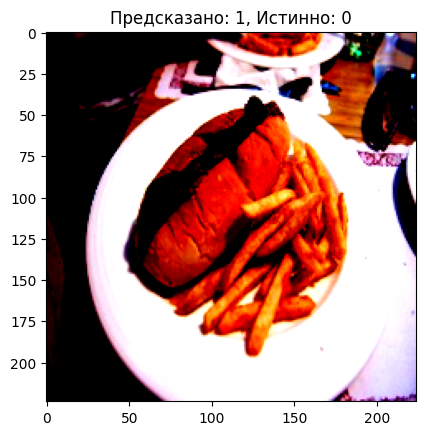

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


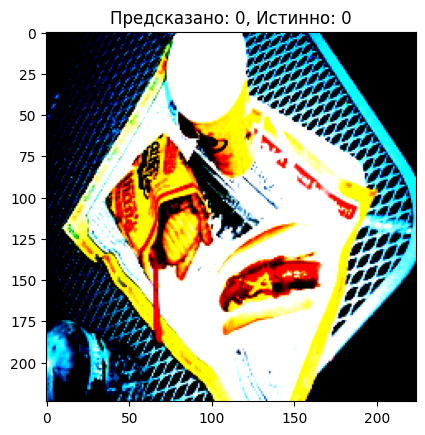

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


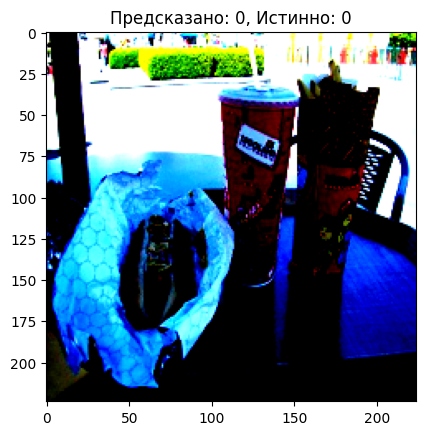

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


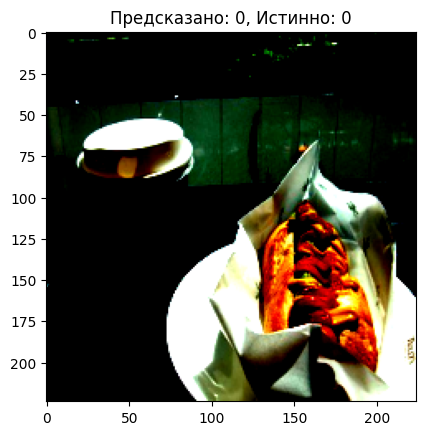

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


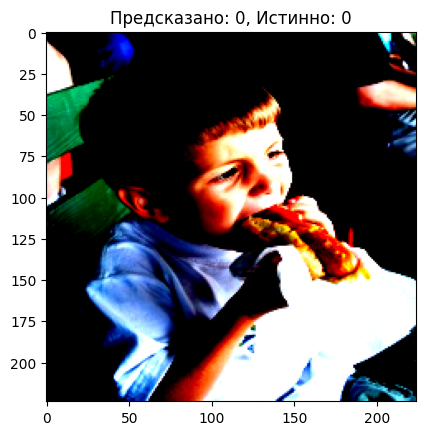

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


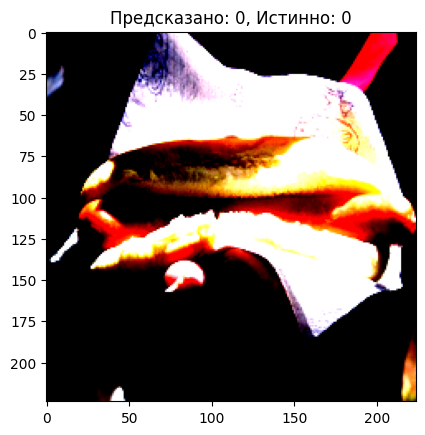

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


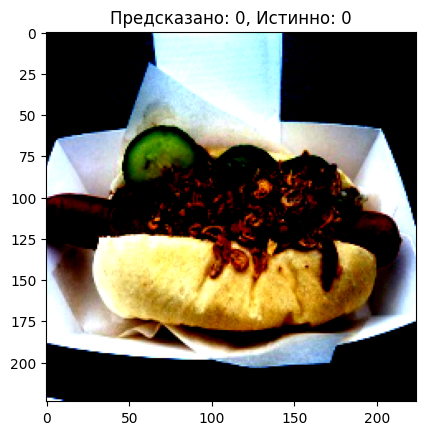

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


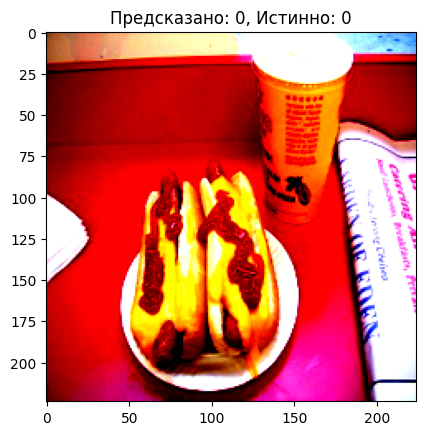

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


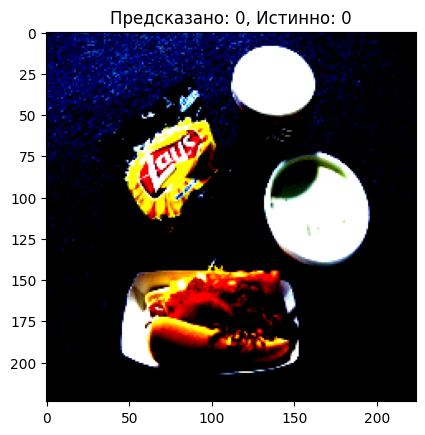

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


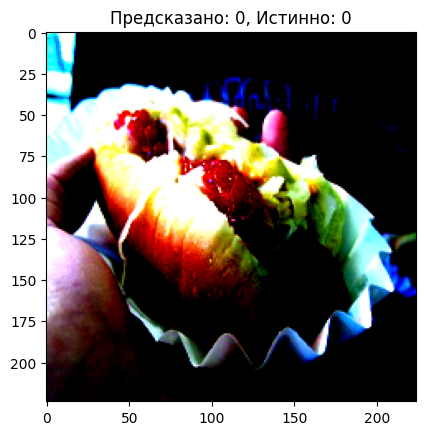

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


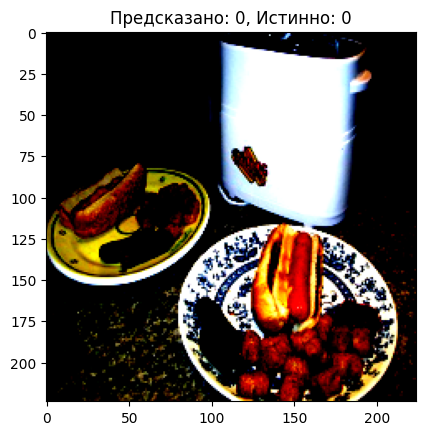

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


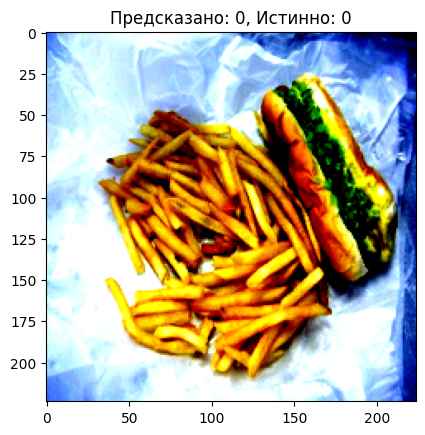

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


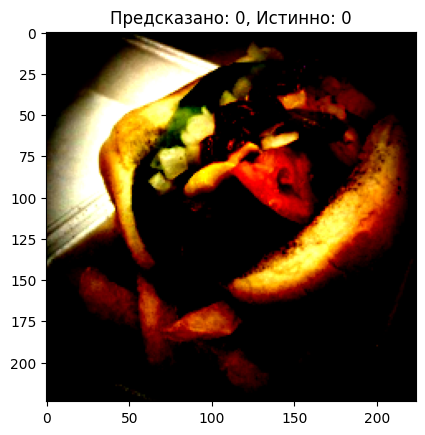

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


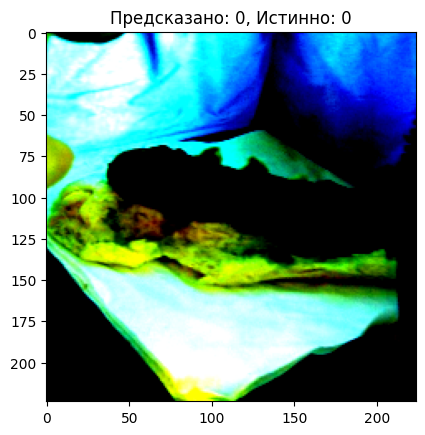

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


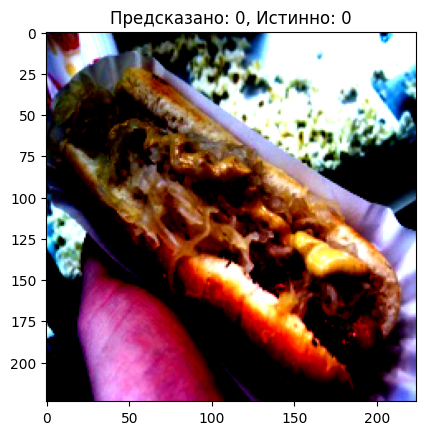

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


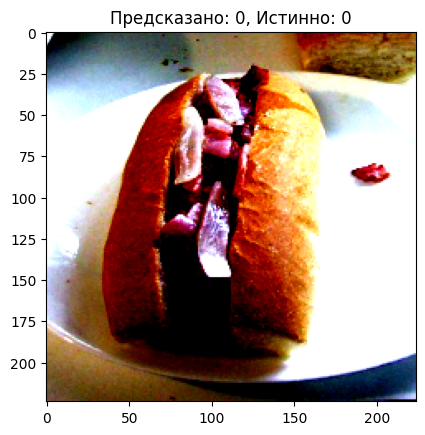

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


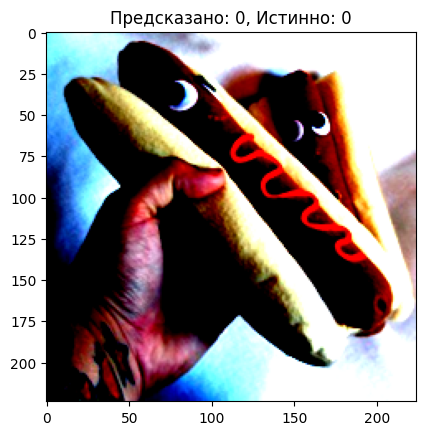

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


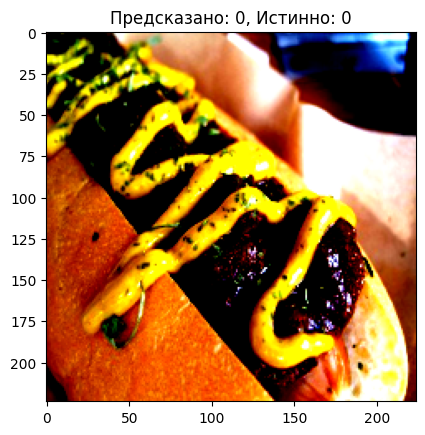

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


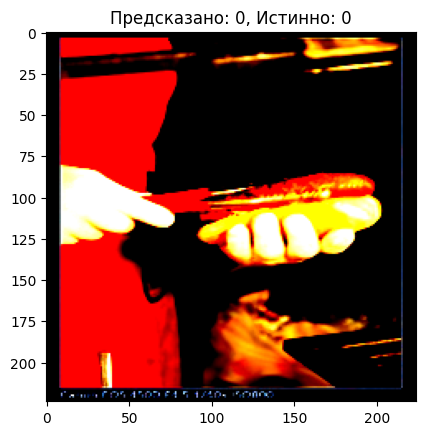

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


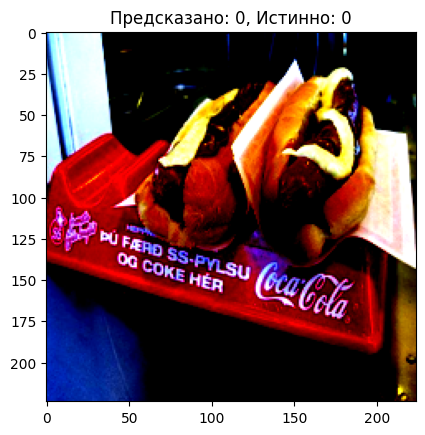

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


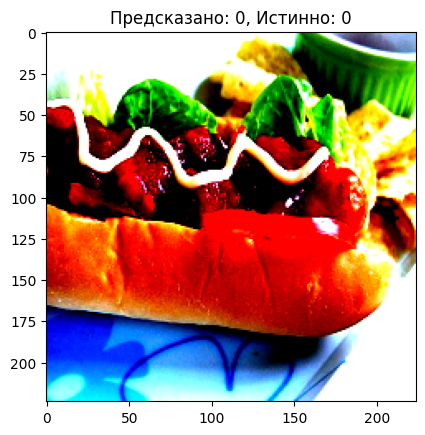

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


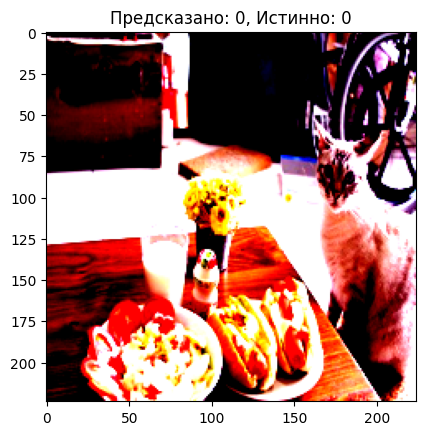

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


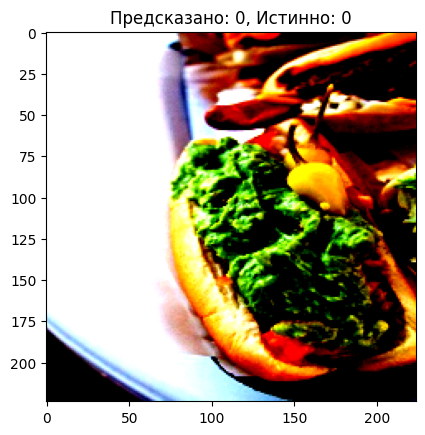

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


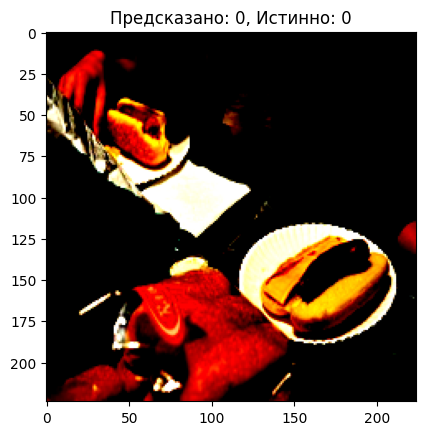

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


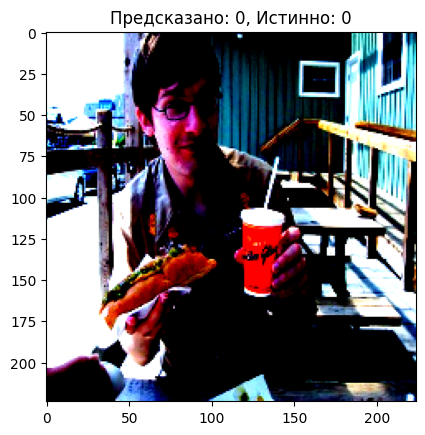

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


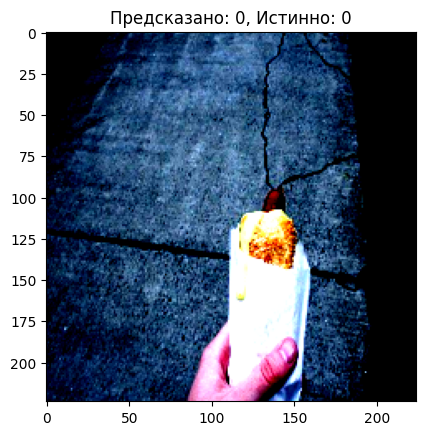

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


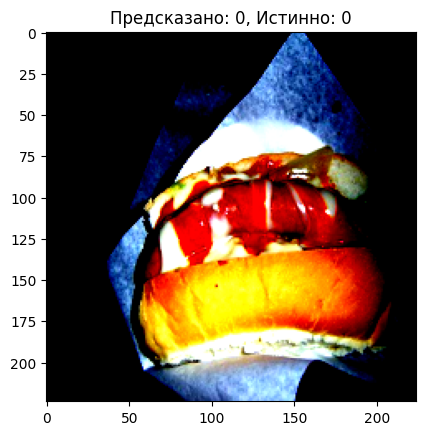

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


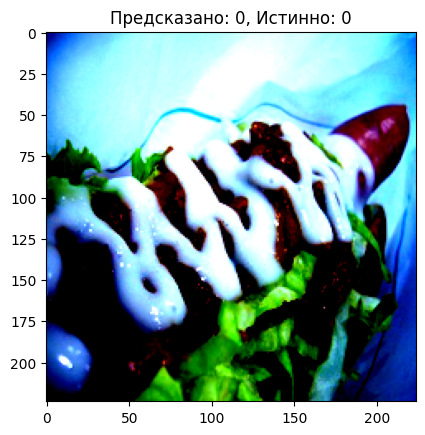

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


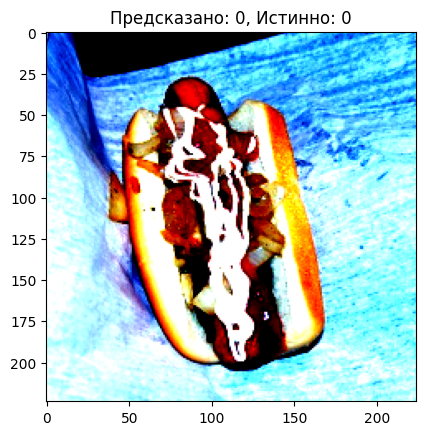

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


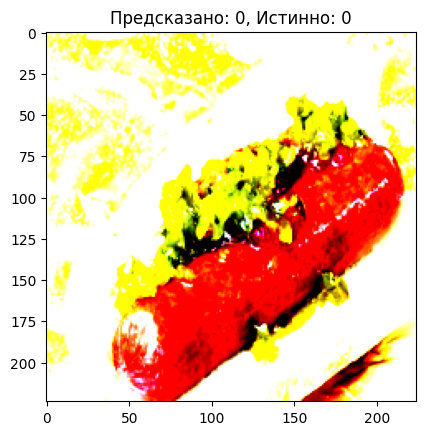

In [293]:
for images, labels in test_loader:
	images, labels = images.to(device), labels.to(device)
	outputs = newnet(images)

	predicted_labels = np.argmax(outputs.cpu().detach(), axis=1)

	images_np = images.cpu().numpy()

	for i in range(len(images_np)):
		plt.imshow(images_np[i].transpose(1, 2, 0))
		plt.title(f'Предсказано: {predicted_labels[i]}, Истинно: {labels[i]}')
		plt.show()
	break